Load package and download data

In [2]:
#@title
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xf cifar-10-python.tar.gz
# !pip install einops
import sys
import pickle
from typing import Tuple
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import imageio
import numpy as np
import numpy.linalg as la
import torch
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from einops import rearrange

torch.cuda.set_device(0)
device = 'cuda:'+str(0)

Define necessary functions

In [3]:
#@title
def softknn(train_features,train_targets,test_features,test_targets,k=30,T=0.03,max_distance_matrix_size=int(5e6),distance_fx: str = "cosine",epsilon: float = 0.00001) -> Tuple[float]:
    """Computes weighted k-NN accuracy @1 and @5. If cosine distance is selected,
    the weight is computed using the exponential of the temperature scaled cosine
    distance of the samples. If euclidean distance is selected, the weight corresponds
    to the inverse of the euclidean distance.
    
    Adopted from https://github.com/vturrisi/solo-learn
    
    Returns:
        Tuple[float]: k-NN accuracy @1 and @5.
    """

    if distance_fx == "cosine":
        train_features = F.normalize(train_features)
        test_features = F.normalize(test_features)

    num_classes = torch.unique(test_targets).numel()
    num_train_images = train_targets.size(0)
    num_test_images = test_targets.size(0)
    num_train_images = train_targets.size(0)
    chunk_size = min(
        max(1, max_distance_matrix_size // num_train_images),
        num_test_images,
    )
    k = min(k, num_train_images)

    top1, top5, total = 0.0, 0.0, 0
    retrieval_one_hot = torch.zeros(k, num_classes).to(train_features.device)
    for idx in range(0, num_test_images, chunk_size):
        # get the features for test images
        features = test_features[idx : min((idx + chunk_size), num_test_images), :]
        targets = test_targets[idx : min((idx + chunk_size), num_test_images)]
        batch_size = targets.size(0)

        # calculate the dot product and compute top-k neighbors
        if distance_fx == "cosine":
            similarities = torch.mm(features, train_features.t())
        elif distance_fx == "euclidean":
            similarities = 1 / (torch.cdist(features, train_features) + epsilon)
        else:
            raise NotImplementedError

        similarities, indices = similarities.topk(k, largest=True, sorted=True)
        candidates = train_targets.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)

        if distance_fx == "cosine":
            similarities = similarities.clone().div_(T).exp_()

        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                similarities.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = (
            top5 + correct.narrow(1, 0, min(5, k, correct.size(-1))).sum().item()
        )  # top5 does not make sense if k < 5
        total += targets.size(0)

    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total

    return top1, top5
    
def visualize_grid(img,figsize=(6,6)):
    """
    Displaying a list of image in grids. 
    Args:
        features: Image with dimension [b, c, h, w].
        figsize: size of the figure being plotted.
    Returns:
        None
    """
    plt.figure(figsize = figsize)
    
    grid_h = int(np.sqrt(len(img)))
    imshow  = rearrange(img[:(len(img)//grid_h)*grid_h],"(h1 w1) c h w ->  (h1 h) (w1 w) c",h1=grid_h)
    plt.imshow(imshow)
    plt.axis('off')
    
# essential function to implement SMT
def sparsify_general1(x, basis, t = 0.3):
    """
    This function gives the general sparse feature for image patch x. We calculte the cosine similarity between
    each image patch x and each dictionary element in basis. If the similarity pass threshold t, then the activation
    is 0, else, the actiavtion is 0. 
    
    Assume both x and basis is normalized.
    
    Args:
        x: Flattened image patches with dimension [bsz, p_w*p_h*c].
        basis: dictionary/codebook with dimension [p_w*p_h*c,num_dict_element], each column of the basis is a dictionary element. 
        t: threshold
    Returns:
        bag_of_patche: List of image patches with size [bsz, c, ps, ps, num_patches]. Each patch has the shape [c, ps, ps]
    """
    
    a = (torch.mm(basis.t(), x) > t).float()
    return a

def unfold_image(imgs,PATCH_SIZE=6,hop_length=2):
    """
    Unfold each image in imgs into a bag of patches.
    Args:
        imgs: Image with dimension [bsz, c, h, w].
        PATCH_SIZE: patch size for each image patch after unfolding, p_h and p_w stands for the height and width of the patch.
    Returns:
        bag_of_patche: List of image patches with size [bsz, c, p_h, p_w, num_patches]. Each patch has the shape [c, p_h, p_w]
    """
    bag_of_patches = F.unfold(imgs, PATCH_SIZE, stride=hop_length)
    bag_of_patches = rearrange(bag_of_patches,"bsz (c p_h p_w) b -> bsz c p_h p_w b",c=3,p_h=PATCH_SIZE)
    return bag_of_patches

def unpickle(file):
    import pickle as cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin1')
    return dict    

Load cifar10

In [4]:
#@title
# Load data from CIFAR10
CIFAR_Path = './cifar-10-batches-py/'
CIFAR_files = []
CIFAR_files.append('data_batch_1')
CIFAR_files.append('data_batch_2')
CIFAR_files.append('data_batch_3')
CIFAR_files.append('data_batch_4')
CIFAR_files.append('data_batch_5')
CIFAR_files_test = []
CIFAR_files_test.append('test_batch')
imgs = torch.zeros([10000 * len(CIFAR_files),32,32,3])
labels = []
for batch_Idx in range(len(CIFAR_files)):
    batch = unpickle(CIFAR_Path + CIFAR_files[batch_Idx])
    data = batch['data']
    for img_idx in range(10000):
        labels.append(batch['labels'][img_idx])
        for color_channel in range(3):
            imgs[img_idx + batch_Idx*10000, :,:,color_channel] = torch.from_numpy( \
                data[img_idx,1024*color_channel:1024*(color_channel+1)].reshape([32,32], order = 'c'))
imgs_test = torch.zeros([10000 * len(CIFAR_files_test),32,32,3])
labels_test = []
for batch_Idx in range(len(CIFAR_files_test)):
    batch = unpickle(CIFAR_Path + CIFAR_files_test[batch_Idx])
    data = batch['data']
    for img_idx in range(10000):
        labels_test.append(batch['labels'][img_idx])
        for color_channel in range(3):
            imgs_test[img_idx + batch_Idx*10000, :,:,color_channel] = torch.from_numpy( \
                data[img_idx,1024*color_channel:1024*(color_channel+1)].reshape([32,32], order = 'c'))

ratio = 10
labels_train = torch.tensor(labels[:len(labels)//ratio])
labels_test = torch.tensor(labels_test[:len(labels_test)//ratio])
imgs_train = imgs[:len(imgs)//ratio].permute(0,3,1,2)
imgs_test = imgs_test[:len(imgs_test)//ratio].permute(0,3,1,2)
imgs_train_reflect = torchvision.transforms.functional.hflip(imgs_train)
imgs_train = torch.cat((imgs_train, imgs_train_reflect))
labels_train = torch.cat((labels_train, labels_train))
del imgs_train_reflect

imgs_train = imgs_train/255.
imgs_test = imgs_test/255.

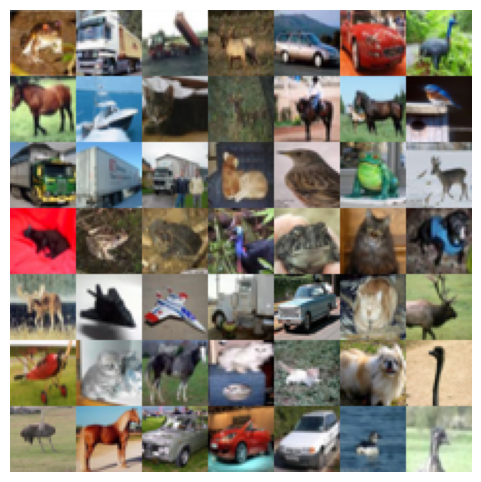

In [6]:
# visualize training samples
visualize_grid(imgs_train[:49,:,:,:])

In [7]:
# Whiten pixel space

BATCH_SIZE = 1000
PATCH_SIZE = 6

# To calculate a covariance matrix in the pixel space for whitening calculation.
V = torch.zeros(PATCH_SIZE**2*3,PATCH_SIZE**2*3).to(device)
BATCH_NUM = 0
for i in tqdm(range(0, imgs_train.size(0), BATCH_SIZE)):
    for j in range(32 - PATCH_SIZE + 1):
        for k in range(32 - PATCH_SIZE + 1):
            patches = imgs_train[i:i+BATCH_SIZE,:,j:j+PATCH_SIZE,k:k + PATCH_SIZE]
            patches = patches.to(device)
            patches = patches.sub(patches.mean((2,3),keepdim =True))
            patches = patches[:,...].reshape(patches.shape[0],-1).t()
            V = V + torch.mm(patches,patches.t())/BATCH_SIZE
            BATCH_NUM +=1
V = V/BATCH_NUM

# Decompose the covariance matrix to obtain the whiten basis. 
w1_c, v1_c = torch.linalg.eig(V + torch.eye(PATCH_SIZE**2*3).to(device) * 1e-7)
w1 = w1_c.real
v1 = v1_c.real
whiteMat = torch.mm((w1.add(1e-3).pow(-0.5)).diag(), v1.t())
colorMat = torch.mm(v1, w1.add(1e-3).pow(0.5).diag())

100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


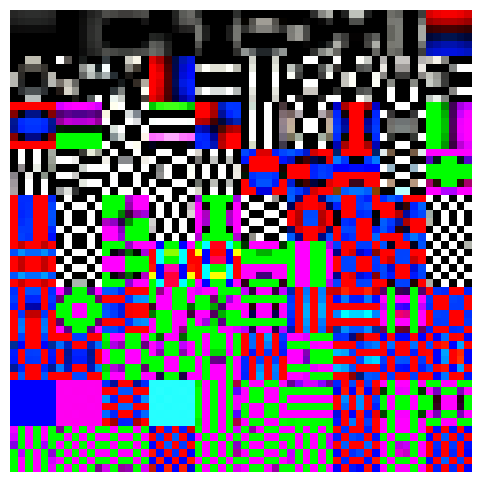

In [8]:
# Visualize the whiten basis:
# Because natural iamge statistic is translational invaraint, the whiten basis resemble the fourier basis.
whiten_basis_vis = rearrange(whiteMat,"bsz (c p_h p_w) -> bsz c p_h p_w", p_h=PATCH_SIZE, p_w = PATCH_SIZE)
visualize_grid(whiten_basis_vis.cpu())

In [9]:
torch.manual_seed(5.23)
BASIS1_NUM = 8192
BASIS1_SIZE = [PATCH_SIZE**2*3, BASIS1_NUM]
basis1 = torch.randn(BASIS1_SIZE).to(device)
basis1_vis = torch.randn(BASIS1_SIZE).to(device)
basis1_vis = torch.randn(BASIS1_SIZE)
#To initialize the dictionary with image patches, we randomly select image patches to be dictionary elements
for i in tqdm(range(BASIS1_NUM)):
    idx = torch.randint(0,imgs_train.size(0),(1,))
    pos = torch.randint(0,32 - PATCH_SIZE+1,(2,))
    patch = imgs_train[idx[0]:idx[0]+1,:,pos[0]:pos[0]+PATCH_SIZE,pos[1]:pos[1] + PATCH_SIZE]
    patches = patch.to(device) 
    patch_rm = patches.sub(patches.mean((2,3),keepdim =True))
    basis1[:,i] = torch.mm(whiteMat, patch_rm[:,...].reshape(1,-1).t())[:,0]
    basis1_vis[:,i] = patch[:,...].reshape(1,-1).t()[:,0].cpu()
    
basis1 = basis1 + 0.001 * torch.rand(basis1.size(), device = device)
basis1 = basis1.div_(basis1.norm(2,0) + 1e-7)

  0%|          | 0/8192 [00:00<?, ?it/s]

100%|██████████| 8192/8192 [00:01<00:00, 4830.61it/s]


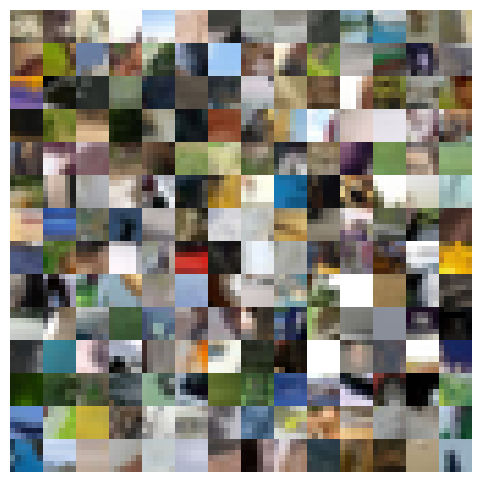

In [10]:
dictionary_vis = rearrange(basis1_vis.T[:200],"bsz (c p_h p_w) -> bsz c p_h p_w", p_h=PATCH_SIZE, p_w = PATCH_SIZE)
visualize_grid(dictionary_vis.cpu())

In [11]:
# Intialize all the parameter we need for solving SMT. 

batch_size=10
hop_length = 1
RG = int((32-PATCH_SIZE)/hop_length)+1
threshold=0.3

basis1 = basis1.to(device)
whiteMat = whiteMat.to(device)
#To build generalized SMT:
BASIS1_NUM = basis1.size(1)
coStat = torch.zeros(BASIS1_NUM,BASIS1_NUM, device=device)
VStat = torch.zeros(BASIS1_NUM,BASIS1_NUM, device=device)
coStat.fill_(0)
VStat.fill_(0)

patches = torch.zeros(RG**2,3,PATCH_SIZE,PATCH_SIZE)
temp1 = torch.zeros(BASIS1_NUM, batch_size, device=device)
temp2 = torch.zeros(BASIS1_NUM, batch_size * RG**2, device=device)

Follow the exact notation in the paper, SMT embedding is the solution to this optimization problem: 
$$\min_{P} ||PAD||_F^2 s.t. $$
This optimization problem has a close-form solution:
$$\text{Let } Q = V^{\frac{1}{2}} AD D^T A^T V^{-\frac{1}{2}}, \text{then } P^* = U V^{-\frac{1}{2}}, \text{where U is a matrix of f trailing eigenvectors of matrix Q}.$$
Thus, in order to calculate the optimal embedding $P^*$, we need to calculate both $V$ and $AD D^T A^T$.

We have $V = AA^T$ as the covaraince matrix.
When D is the first order derivative and the context is the entire image with $t^2$ patches, let $Co$ be the co-occurence matrix of sparse fecture we have: $AD D^T A^T = t^2 V - Co$, please refer the derivation to the appendix.



### To summarize, in order to calculate the optimal embedding $P^*$, all we need is covariance matrix $V$ and co-occurence matrix $Co$.

Let $C$ be context window, it's a set of index where all pairs of index in $C$ are neighbors, then we calculate $V$ and $Co$ by only passing through the dataset once:

### $V = \sum_C \sum_{i \in C} a_i a_i^T$

### $Co = \sum_C \bar{a_C} \bar{a_C}^T, \text{where } \bar{a_C} = \sum_{i \in C} a_i $

In [12]:
# Training (collecting co-variance and co-occurence)
for idx in tqdm(range(0,imgs_train.size(0), batch_size)):
#     unfold each image into a bag of patches
    patches =unfold_image(imgs_train[idx:idx+batch_size].to(device),PATCH_SIZE=PATCH_SIZE,hop_length=hop_length)
#     demean/center each image patch
    patches = patches.sub(patches.mean((2,3),keepdim =True))
#     aggregate all patches into together (squeeze into one dimension).
    x = rearrange(patches,"bsz c p_h p_w b  ->bsz (c p_h p_w) b ")
    x_flat = rearrange(x,"bsz p_d hw -> p_d (bsz hw)")
#     apply whiten transform to each image patch
    x_flat = torch.mm(whiteMat, x_flat)
#     normalize each image patch
    x_flat = x_flat.div(x_flat.norm(dim = 0, keepdim=True)+1e-9)
#     extract sparse feature vector ahat from each image patch, sparsify_general1 is f_gq in the paper
    ahat = sparsify_general1(x_flat, basis1, t=threshold)
#     Average sparse feacture over current context window
    ahat_bar = rearrange(ahat,"c (b hw) -> c b hw",b=batch_size).sum(-1)
#     update co-occurence statistic
    temp = torch.mm(ahat_bar, ahat_bar.t())
    coStat.add_(temp); del temp; torch.cuda.empty_cache()
#     update co-variance statistic
    temp = torch.mm(ahat, ahat.t())
    VStat.add_(temp); del temp; torch.cuda.empty_cache()
del temp1, ahat, x; torch.cuda.empty_cache()

100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


In [11]:
# move off gpu, free cache
# VStat_c = VStat.cpu(); coStat_c = coStat.cpu(); del VStat, coStat; torch.cuda.empty_cache()

In [13]:
# move off gpu, free cache
# VStat_c = VStat.cpu(); coStat_c = coStat.cpu(); del VStat, coStat; torch.cuda.empty_cache()
# The following derives the SMT embedding for the feature function:
ADDA = RG**2 * VStat - coStat
wV, vV = torch.linalg.eigh(VStat, UPLO='U')
wV = wV.clamp_(min=0.000001)
V_invhalf = torch.mm(vV, torch.mm(wV.pow(-0.5).diag(),vV.t()))
Q = torch.mm(V_invhalf, torch.mm(ADDA, V_invhalf))
wQ, vQ = torch.linalg.eigh(Q, UPLO='U')

In [14]:
num_dim = 512
U = vQ[:,8:8+num_dim]
P_star = torch.mm(V_invhalf, U).t().to(device)

In [15]:
# # Manifold learning without temperal constraint
# num_dim = 4096
# P_star = vV[:,:num_dim].T.to(device)
P_star = torch.eye(8192,8192).to(device)
P_star = vV[:,:].T.to(device)
num_dim = P_star.shape[1]

In [176]:
# patial pooling to aggregate patch embedding in to image embedding
output_w = 3
temp_train_1 = torch.zeros([imgs_train.size(0),num_dim,output_w,output_w])
temp_test_1 = torch.zeros([imgs_test.size(0),num_dim,output_w,output_w])
temp_train_1.fill_(0)
temp_test_1.fill_(0)

# for epoch in range(4):
for idx in tqdm(range(0,imgs_train.size(0), batch_size)):
#     unfold each image into a bag of patches
    patches =unfold_image(imgs_train[idx:idx+batch_size].to(device),PATCH_SIZE=PATCH_SIZE,hop_length=hop_length)
#     demean/center each image patch
    patches = patches.sub(patches.mean((2,3),keepdim =True))
#     aggregate all patches into together (squeeze into one dimension).
    x = rearrange(patches,"bsz c p_h p_w b  ->bsz (c p_h p_w) b ")
    x_flat = rearrange(x,"bsz p_d hw -> p_d (bsz hw)")
#     apply whiten transform to each image patch
    x_flat = torch.mm(whiteMat, x_flat)
#     normalize each image patch
    x_flat = x_flat.div(x_flat.norm(dim = 0, keepdim=True)+1e-9)
#     extract sparse feature vector ahat from each image patch, sparsify_general1 is f_gq in the paper
    ahat = sparsify_general1(x_flat, basis1, t=threshold)
#     project the sparse code into the spectral embeddings
    temp = torch.mm(P_star, ahat)
    temp = temp.div(temp.norm(dim=0, keepdim=True)+ 1e-9)
    temp = rearrange(temp,"c (b2 h w) -> b2 c h w",b2=batch_size,h=RG)
#     apply spatial pooling
    temp_train_1[idx:idx+batch_size,...] = F.adaptive_avg_pool2d(F.avg_pool2d(temp, kernel_size = 5, stride = 3), output_w)

for idx in tqdm(range(0,imgs_test.size(0), batch_size)):
#     unfold each image into a bag of patches
    patches =unfold_image(imgs_test[idx:idx+batch_size].to(device),PATCH_SIZE=PATCH_SIZE,hop_length=hop_length)
#     demean/center each image patch
    patches = patches.sub(patches.mean((2,3),keepdim =True))
#     aggregate all patches into together (squeeze into one dimension).
    x = rearrange(patches,"bsz c p_h p_w b  ->bsz (c p_h p_w) b ")
    x_flat = rearrange(x,"bsz p_d hw -> p_d (bsz hw)")
#     apply whiten transform to each image patch
    x_flat = torch.mm(whiteMat, x_flat)
#     normalize each image patch
    x_flat = x_flat.div(x_flat.norm(dim = 0, keepdim=True)+1e-9)
#     extract sparse feature vector ahat from each image patch, sparsify_general1 is f_gq in the paper
    ahat = sparsify_general1(x_flat, basis1, t=threshold)
#     project the sparse code into the spectral embeddings
    temp = torch.mm(P_star, ahat)
    temp = temp.div(temp.norm(dim=0, keepdim=True)+ 1e-9)
    temp = rearrange(temp,"c (b2 h w) -> b2 c h w",b2=batch_size,h=RG)
#     apply spatial pooling
    temp_test_1[idx:idx+batch_size,...] = F.adaptive_avg_pool2d(F.avg_pool2d(temp, kernel_size = 5, stride = 3), output_w)

temp_train_1 = temp_train_1.div(temp_train_1.norm(dim=(-3), keepdim=True) + 1e-9)
temp_test_1 = temp_test_1.div(temp_test_1.norm(dim=(-3), keepdim=True) + 1e-9)

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 46.40it/s]


In [177]:
temp_test_1.shape

torch.Size([1000, 8192, 3, 3])

In [170]:
# acc = softknn(temp_train_1.flatten(1),labels_train,temp_test_1.flatten(1),labels_test,k=30,T=0.03)

In [171]:
# acc

In [172]:
X = temp_train_1.flatten(start_dim = 1,end_dim = -1).numpy()
X_test = temp_test_1.flatten(start_dim = 1,end_dim = -1).numpy()
# X  = temp_train_1.mean(dim = [-1,-2]).numpy()
# X_test  = temp_test_1.mean(dim = [-1,-2]).numpy()
y = labels_train
y_test = labels_test

In [173]:
from sklearn.metrics import accuracy_score
from snapml import LogisticRegression
clf = LogisticRegression(use_gpu = True, device_ids = [0,1], fit_intercept=True,penalty='l2',batch_size=1000,regularizer=1)
clf.fit(X,y)
y_test_hat = clf.predict(X_test)
acc_score = accuracy_score(y_test,y_test_hat)

In [174]:
print(acc_score)

0.706


In [139]:
print(acc_score)

0.709
